# Human presence sub-model - Notebook 3

* **Products used:** 
[cgls_landcover](https://explorer.digitalearth.africa/products/cgls_landcover), 
[OpenStreetMap](https://www.openstreetmap.org/),
[High Resolution Population Density Maps + Demographic Estimates by CIESIN and Meta](https://registry.opendata.aws/dataforgood-fb-hrsl/)

## Background

This notebook calculates and stores the first sub-model in the elephant Habitat Suitability Model; the human presence sub-model. It has the data layers and weightings listed in the table below. 


Data layer | Layer weighting |
-----------: | -----------: |
Urban development (CGLS 50) | 25% | 
Cropland (CGLS 40) | 25% |
Human population density | 25% |
Roads | 25% |

The workflow comprises the following steps:

   1. Define an area of interest and load packages.
   2. Load landcover CGLS data and select the cropland and urban cover layers.
   3. Within the area of interest, calculate proximity to croplands and urban areas quantified as euclidean distance in metres.
   4. Standardise the euclidean distance measure so it ranges between 0 and 1.
   5. Use a weighted linear combination approach to estimate habitat suitability.
   6. Visualise the habitat suitability model.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from odc.algo import xr_reproject
from deafrica_tools.plotting import display_map, plot_lulc
from deafrica_tools.spatial import xr_vectorize, xr_rasterize

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
try:
    import osmnx as ox
except:
    import os
    os.system('pip install osmnx')
    import osmnx as ox

In [3]:
try:
      import xrspatial
except:
      !pip install xrspatial
    
from xrspatial import proximity

/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app='Elephant-HSM-human')

## Load CGLS landcover

In [7]:
#create reusable datacube query object
%store -r query

ds_cgls = dc.load(product='cgls_landcover', **query).squeeze()

ds_cgls

<xarray.Dataset>
Dimensions:         (y: 3618, x: 2895)
Coordinates:
    time            datetime64[ns] 2019-07-02T11:59:59.500000
  * y               (y) float64 -2.047e+06 -2.048e+06 ... -2.770e+06 -2.771e+06
  * x               (x) float64 1.416e+06 1.417e+06 ... 1.995e+06 1.995e+06
    spatial_ref     int32 6933
Data variables:
    classification  (y, x) uint8 126 126 126 20 126 20 126 ... 20 20 20 20 20 20
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

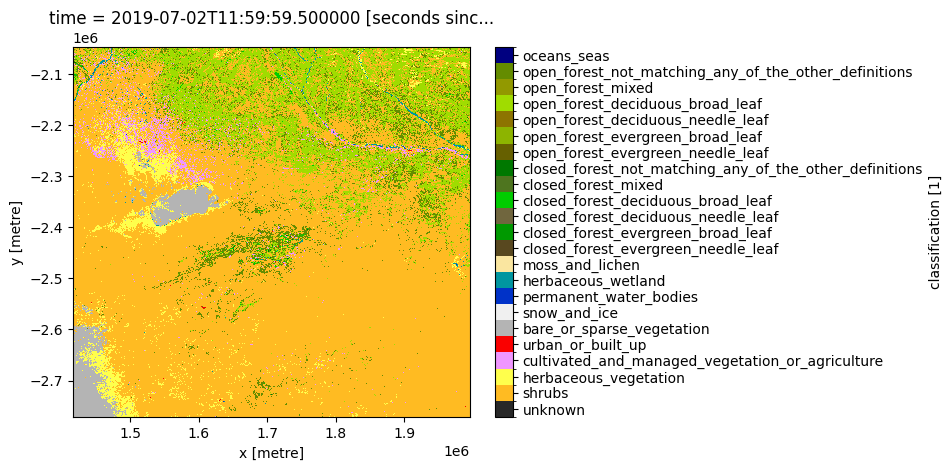

In [8]:
plot_lulc(ds_cgls.classification, product="CGLS", legend=True)

# Urban development

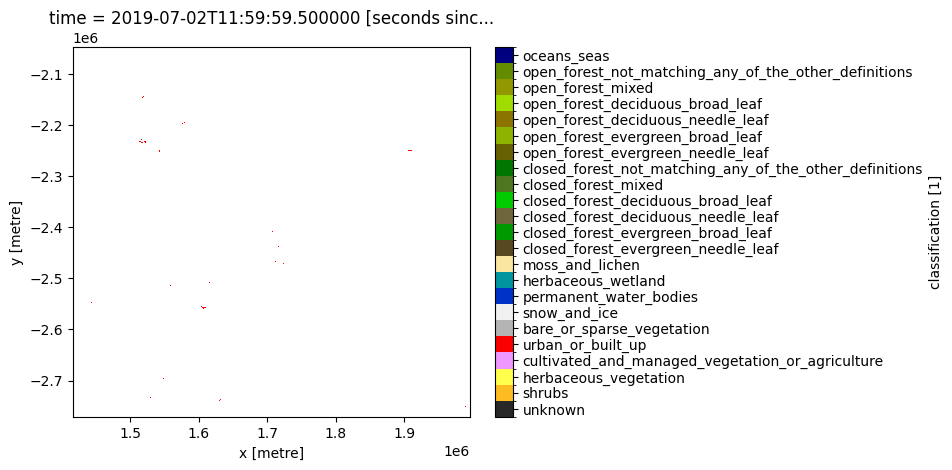

In [9]:
plot_lulc(ds_cgls.where(ds_cgls==50)['classification'], product="CGLS", legend=True)

In [10]:
cgls_urban = ds_cgls.where(ds_cgls==50)

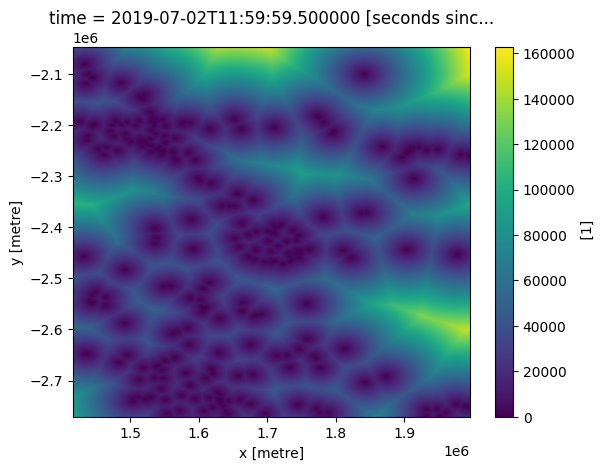

In [11]:
urban_proximity = proximity(cgls_urban.classification, distance_metric='EUCLIDEAN')
urban_proximity.plot()

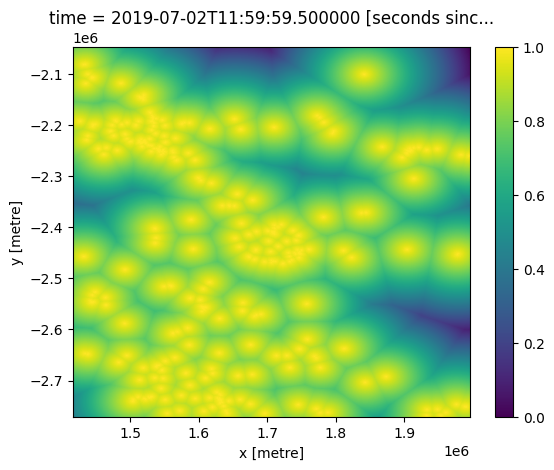

In [12]:
urban_proximity_std = 1 - (urban_proximity/np.max(urban_proximity))

urban_proximity_std.plot()

## Croplands

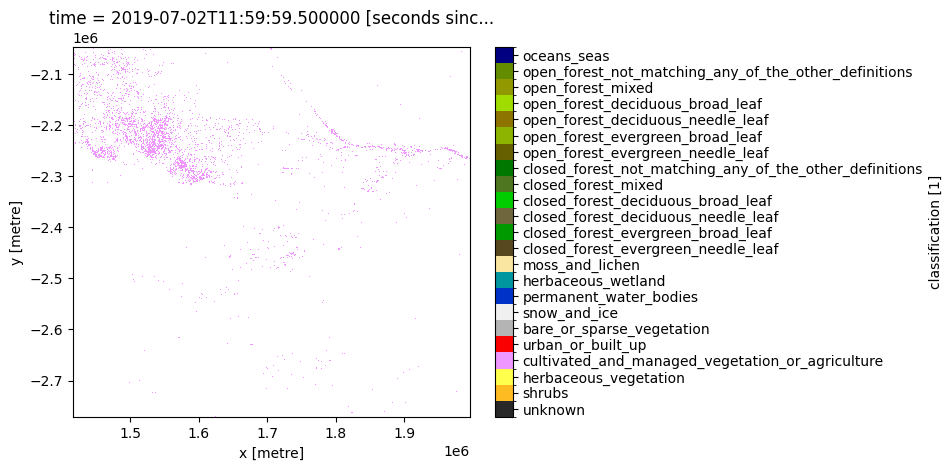

In [13]:
plot_lulc(ds_cgls.where(ds_cgls==40)[measurements], product="CGLS", legend=True)

In [14]:
cgls_crops = ds_cgls.where(ds_cgls==40)

In [15]:
proximity_crops = proximity(cgls_crops.classification, distance_metric = 'EUCLIDEAN')

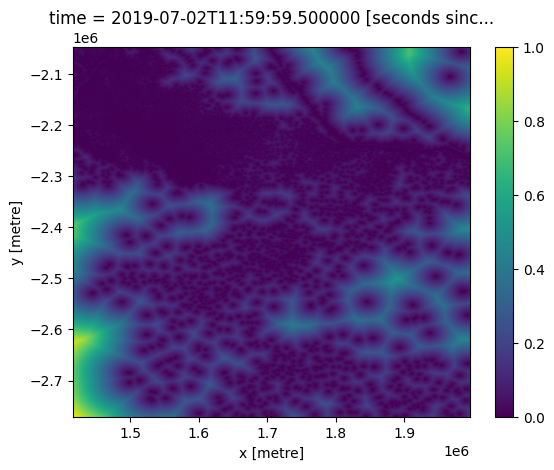

In [16]:
crops_proximity_std = (proximity_crops/np.max(proximity_crops))

crops_proximity_std.plot()

# Population density data

In [17]:
os.environ['AWS_DEFAULT_REGION']="us-east-1"
os.environ['AWS_S3_ENDPOINT']="s3.us-east-1.amazonaws.com"

In [18]:
ds_general = rxr.open_rasterio('s3://dataforgood-fb-data/hrsl-cogs/hrsl_general/hrsl_general-latest.vrt', chunks ={'x': 1000, 'y': 1000})

In [19]:
%store -r lons
%store -r lats

xmin = lons[0]
xmax = lons[1]
ymin = lats[0]
ymax = lats[1]

# load the data within area of interest
pop_general = ds_general.isel(band=0).sel(x=slice(
    xmin, xmax), y = slice(ymax, ymin)).coarsen(
    x=6).mean().coarsen(y=6).mean().compute().rio.reproject("EPSG:6933")

/usr/local/lib/python3.8/dist-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [20]:
popn_proximity = proximity(pop_general, distance_metric='EUCLIDEAN')

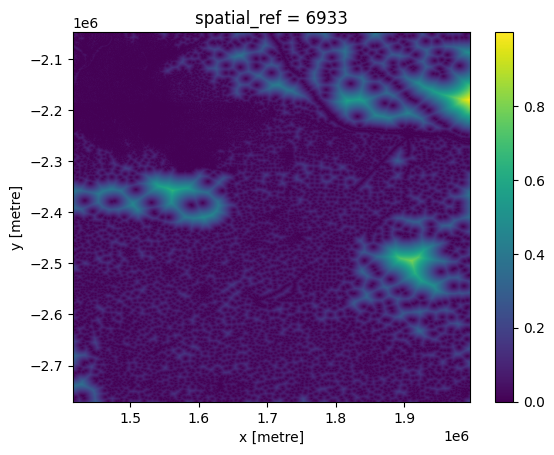

In [21]:
popn_proximity_std = (popn_proximity/np.max(popn_proximity))

popn_proximity_std = xr_reproject(src=popn_proximity_std,
                              geobox=ds_cgls.geobox,
                              resampling="average")

popn_proximity_std.plot()

# Roads - Open Street Map

In [22]:
ox.settings.cache_folder='/tmp/cache/'

In [23]:
# selected types of roads
tags = {'highway': ['motorway', 'motorway_link', 'primary', 'primary_link',
                    'secondary', 'secondary_link', 'tertiary', 'tertiary_link', 
                    'residential', 'pedestrian']}

In [24]:
#noting the order of the bounds provided
geometries = ox.geometries_from_bbox(ymax, ymin, xmax, xmin, tags)

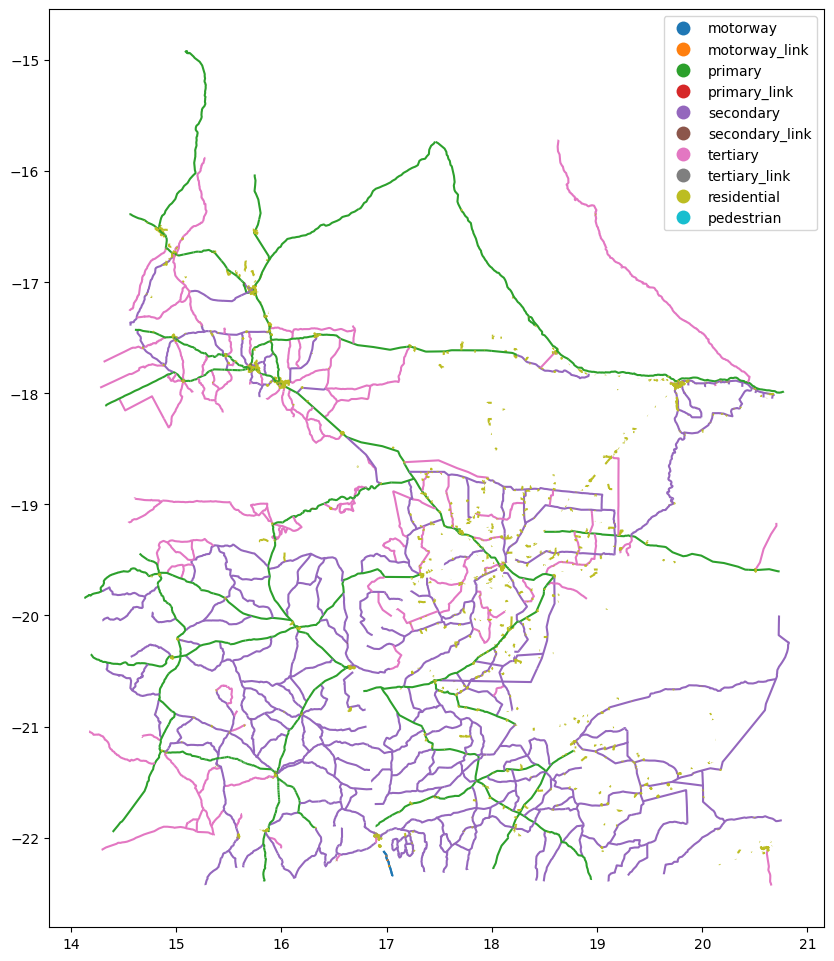

In [25]:
#visualize the geometries retrieved
geometries.plot(figsize=(10,12), cmap='tab10', column='highway', categorical=True, categories=tags['highway'], legend=True);

In [26]:
xr_roads = xr_rasterize(geometries, da=ds_cgls)

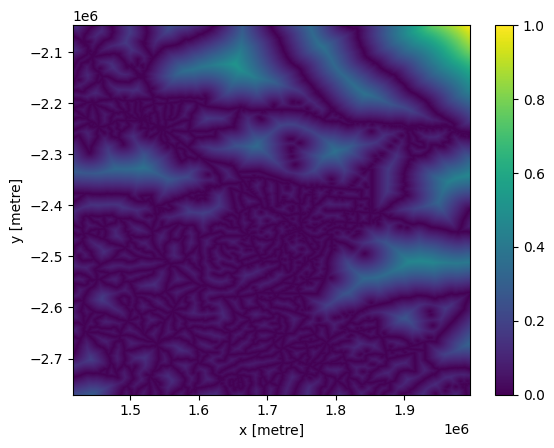

In [27]:
roads_proximity = proximity(xr_roads, distance_metric='EUCLIDEAN')

roads_proximity_std = (roads_proximity/np.max(roads_proximity))
roads_proximity_std.plot()

# Weighted Linear Combination

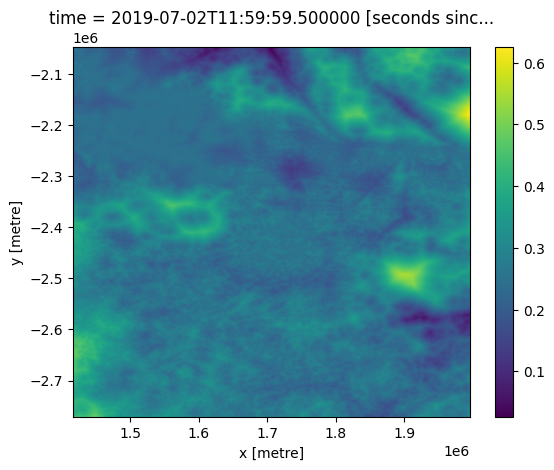

In [28]:
weight=0.25

hp_model=(roads_proximity_std*weight)+(
    urban_proximity_std*weight)+(
    popn_proximity_std*weight)+(
    crops_proximity_std*weight)

hp_model.plot()

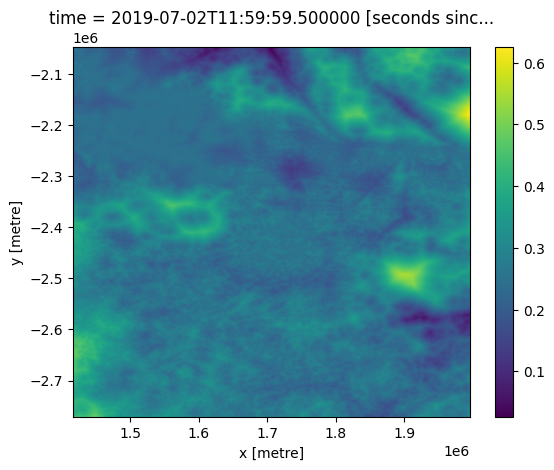

In [29]:
hp_model.plot()

## Save to outputs

In [30]:
hp_model = hp_model.drop('time', dim=None)
hp_model.to_netcdf('outputs/hp_sm.nc')

/usr/local/lib/python3.8/dist-packages/xarray/core/dataarray.py:2365: PendingDeprecationWarning: dropping variables using `drop` will be deprecated; using drop_vars is encouraged.
  ds = self._to_temp_dataset().drop(labels, dim, errors=errors)


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [31]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [32]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-04-13'